# INTRODUCTION
#### This notebook is has taken direct inspiration from [Notebook](https://www.kaggle.com/code/cdeotte/gpu-lightgbm-baseline-cv-681-lb-685) by cdeotte Chris Deotte baseline notebook  
#### My Changes :
<ul>Used single Xgboost model with NelsonAalenFitter </ul>
<ul>Modified the target by modifying target with efs=0 </ul>
<ul>Used stratified Kfold with race group</ul>
<ul>A bit of hyperparamter tuning</ul>

# Load Train and Test

In [24]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("test.csv")
print("Test shape:", test.shape )
train = pd.read_csv("train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [25]:
RMV = ["ID","efs","efs_time","y","efs_time2"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [26]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [27]:
from lifelines import  NelsonAalenFitter
def create_nelson(data):
    data=data.copy()
    naf = NelsonAalenFitter(nelson_aalen_smoothing=0)
    naf.fit(durations=data['efs_time'], event_observed=data['efs'])
    return naf.cumulative_hazard_at_times(data['efs_time']).values*-1

In [28]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    if c in CATS:
        print(f"{c}, ",end="") #Normalize and reduce memory usage
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")

    else:
        if combined[c].dtype=="float64": #Reduce memory usage
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [29]:
from sklearn.model_selection import KFold,StratifiedKFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 3.0.0


# Target transformation

In [30]:
# The Nelson-Aalen estimator is a non-parametric estimator of the cumulative hazard function in survival analysis. It's commonly used to estimate the cumulative probability of experiencing an event over time.

train["y_nel"] = create_nelson(train)

print(train[["efs", "efs_time", "y_nel"]].head())
print(train.y_nel.min())

   efs  efs_time     y_nel
0  0.0    42.356 -0.779331
1  1.0     4.672 -0.165150
2  0.0    19.793 -0.771216
3  0.0   102.349 -0.783756
4  0.0    16.223 -0.766364
-0.7923866866657324


efs: Likely represents the event-free survival status (whether an event occurred or not)

efs_time: The time until the event or censoring

y_nel: The newly created Nelson-Aalen estimates

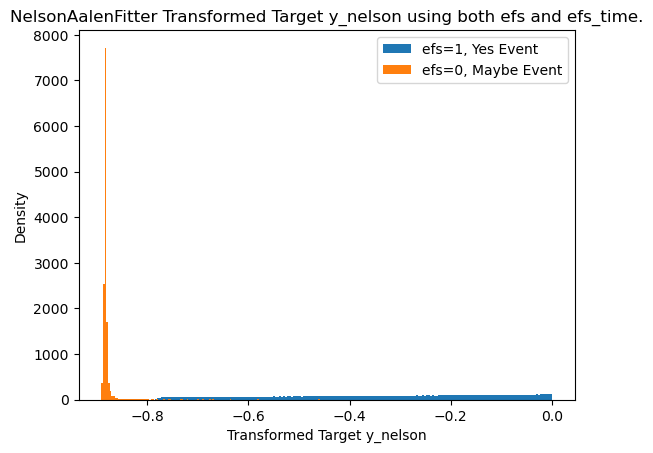

In [31]:
#important
train.loc[train.efs == 0, "y_nel"] = (-(-train.loc[train.efs == 0, "y_nel"])**0.5)

plt.hist(train.loc[train.efs==1,"y_nel"],bins=200,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y_nel"],bins=200,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y_nelson")
plt.ylabel("Density")
plt.title("NelsonAalenFitter Transformed Target y_nelson using both efs and efs_time.")
plt.legend()
plt.show()

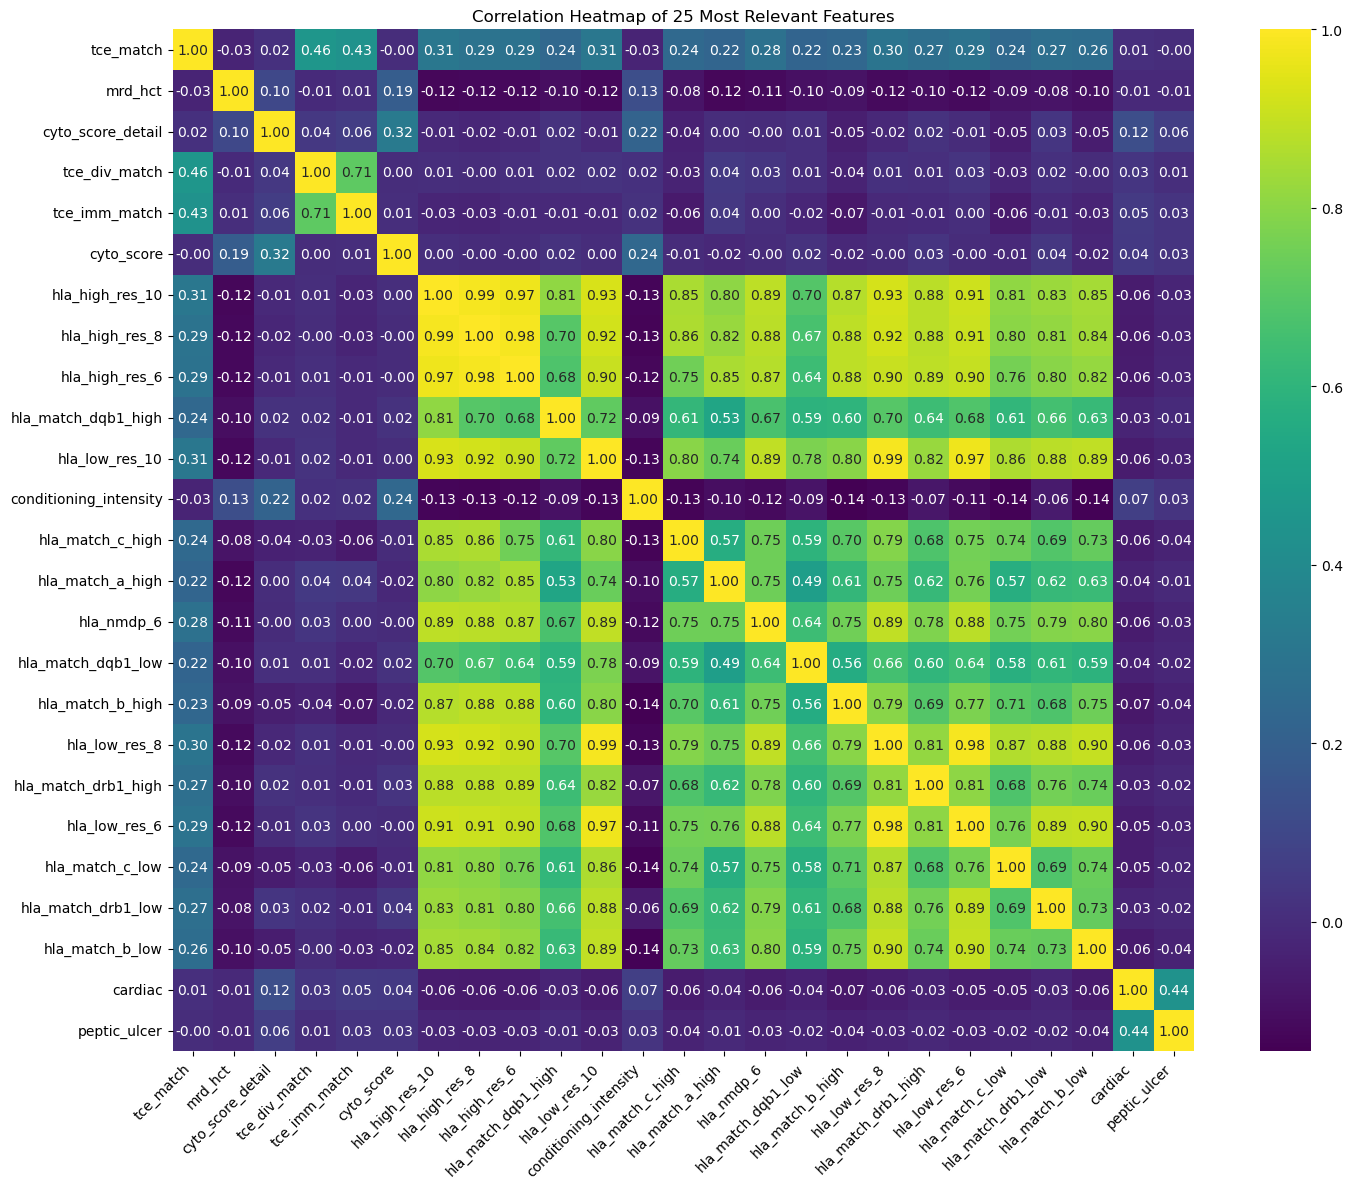

In [32]:
# Select the 25 most relevant columns based on feature importance
most_relevant_cols = [
    'tce_match', 'mrd_hct', 'cyto_score_detail', 'tce_div_match', 'tce_imm_match',
    'cyto_score', 'hla_high_res_10', 'hla_high_res_8', 'hla_high_res_6',
    'hla_match_dqb1_high', 'hla_low_res_10', 'conditioning_intensity',
    'hla_match_c_high', 'hla_match_a_high', 'hla_nmdp_6', 'hla_match_dqb1_low',
    'hla_match_b_high', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_6',
    'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_b_low', 'cardiac',
    'peptic_ulcer'
]

# Create a new DataFrame with only the selected features
df_selected = train[most_relevant_cols]

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', square=True)
plt.title('Correlation Heatmap of 25 Most Relevant Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
train['y_nel']

0       -0.882797
1       -0.165150
2       -0.878189
3       -0.885300
4       -0.875422
           ...   
28795   -0.877670
28796   -0.191762
28797   -0.879769
28798   -0.883146
28799   -0.880417
Name: y_nel, Length: 28800, dtype: float64

# Race based Stratified Kfold

In [34]:
%%time
FOLDS = 10
def create_stratified_folds(data, target, n_splits=10):
    data['fold'] = -1
    # num_bins = int(np.floor(1 + np.log2(len(data))))  # Sturges' rule for binning
    if (target!="race_group"):
        data['bins'] = pd.qcut(data[target], q=50, duplicates='drop',labels=False)
    data["bins"]=data["race_group"]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(data, data['bins'])):
        data.loc[val_idx, 'fold'] = fold

    data = data.drop(columns=['bins'])
    return data

train=create_stratified_folds(train,"race_group",FOLDS)

CPU times: total: 15.6 ms
Wall time: 20.1 ms


# Model training

In [35]:
oof_xgb1 = np.zeros(len(train))
pred_xgb1 = np.zeros(len(test))

for i in range(FOLDS):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train.fold!=i,FEATURES].copy()
    y_train = train.loc[train.fold!=i,"y_nel"]
    x_valid = train.loc[train.fold==i,FEATURES].copy()
    y_valid = train.loc[train.fold==i,"y_nel"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        # device="cuda",
        max_depth=4,
        colsample_bytree=0.55,
        subsample=0.8,
        n_estimators=5000,
        learning_rate=0.02,
        enable_categorical=True,
        min_child_weight=80,
        early_stopping_rounds=200,
        n_jobs=4
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb1[train.index[train.fold==i]] = (model_xgb.predict(x_valid))
    # INFER TEST
    pred_xgb1 += (model_xgb.predict(x_test))

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.31529
[500]	validation_0-rmse:0.28339
[1000]	validation_0-rmse:0.28077
[1500]	validation_0-rmse:0.27982
[2000]	validation_0-rmse:0.27936
[2500]	validation_0-rmse:0.27906
[2691]	validation_0-rmse:0.27905
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.31627
[500]	validation_0-rmse:0.28255
[1000]	validation_0-rmse:0.27924
[1500]	validation_0-rmse:0.27794
[2000]	validation_0-rmse:0.27721
[2500]	validation_0-rmse:0.27689
[2636]	validation_0-rmse:0.27687
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.31540
[500]	validation_0-rmse:0.28426
[1000]	validation_0-rmse:0.28144
[1500]	validation_0-rmse:0.28039
[2000]	validation_0-rmse:0.28009
[2271]	validation_0-rmse:0.28015
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.31465
[500]	validation_0-rmse:0.28056
[1000]	validation_0-rmse:0.27839
[1500

In [37]:
# Import C-index metric
from sksurv.metrics import concordance_index_censored

y_true = train[["efs","efs_time"]].copy()  # Select 'efs' and 'efs_time' for event indicator and time
y_pred = oof_xgb1 # Predictions from your model

# Calculate the C-index
m = concordance_index_censored(y_true["efs"].astype(bool), y_true["efs_time"], y_pred)
print(f"\nOverall CV for XGBoost NelsonAalenFitter =", m[0])


Overall CV for XGBoost NelsonAalenFitter = 0.6900788517367274


In [ ]:
224790615 / (100843520 + 224790615)

0.6903164958427961

# Final submission

In [ ]:
sub = pd.read_csv("/content/drive/MyDrive/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = rankdata(pred_xgb1)

sub.to_csv("submission.csv",index=False)

In [ ]:
# Train XGBClassifier
oof_xgb2 = np.zeros(len(train))
pred_xgb2 = np.zeros(len(test))

for i in range(FOLDS):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train.loc[train.fold!=i,FEATURES].copy()
    y_train = train.loc[train.fold!=i,"efs"]
    x_valid = train.loc[train.fold==i,FEATURES].copy()
    y_valid = train.loc[train.fold==i,"efs"]
    x_test = test[FEATURES].copy()

    clf_xgb = XGBClassifier(
        max_depth=4,
        colsample_bytree=0.55,
        subsample=0.8,
        n_estimators=5000,
        learning_rate=0.02,
        enable_categorical=True,
        min_child_weight=80,
        early_stopping_rounds=200,
        n_jobs=4
    )
    clf_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500
    )

    # INFER OOF
    oof_xgb2[train.index[train.fold==i]] = (clf_xgb.predict(x_valid))
    # INFER TEST
    pred_xgb2 += (clf_xgb.predict(x_test))

#########################
### Fold 1
#########################
[0]	validation_0-logloss:0.68829
[500]	validation_0-logloss:0.58179
[1000]	validation_0-logloss:0.57590
[1500]	validation_0-logloss:0.57405
[1906]	validation_0-logloss:0.57383
#########################
### Fold 2
#########################
[0]	validation_0-logloss:0.68813
[500]	validation_0-logloss:0.58027
[1000]	validation_0-logloss:0.57211
[1500]	validation_0-logloss:0.56823
[2000]	validation_0-logloss:0.56740
[2500]	validation_0-logloss:0.56718
[2632]	validation_0-logloss:0.56721
#########################
### Fold 3
#########################
[0]	validation_0-logloss:0.68768
[500]	validation_0-logloss:0.58762
[1000]	validation_0-logloss:0.58284
[1500]	validation_0-logloss:0.58198
[1613]	validation_0-logloss:0.58219
#########################
### Fold 4
#########################
[0]	validation_0-logloss:0.68807
[500]	validation_0-logloss:0.58954
[1000]	validation_0-logloss:0.58329
[1500]	validation_0-logloss:0.58204
[2000]	v

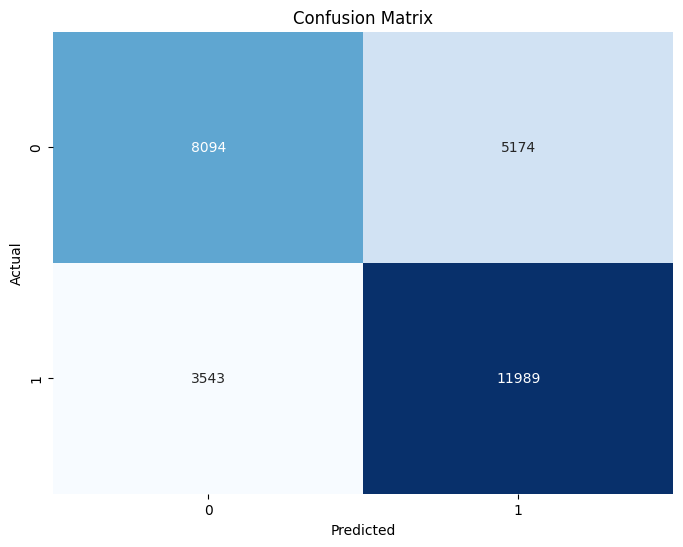

In [ ]:
# Confusion matrix for clf_xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = train["efs"].copy()
y_pred = oof_xgb2

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.70      0.61      0.65     13268
         1.0       0.70      0.77      0.73     15532

    accuracy                           0.70     28800
   macro avg       0.70      0.69      0.69     28800
weighted avg       0.70      0.70      0.69     28800



In [ ]:
# Train a clustering DBSCAN model
from sklearn.cluster import DBSCAN

train_cluster = train.dropna()

cluster = DBSCAN(eps=100, min_samples=5)
train_cluster['cluster'] = cluster.fit_predict(train_cluster[FEATURES])

<ipython-input-27-223f2382a0db>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cluster['cluster'] = cluster.fit_predict(train_cluster[FEATURES])


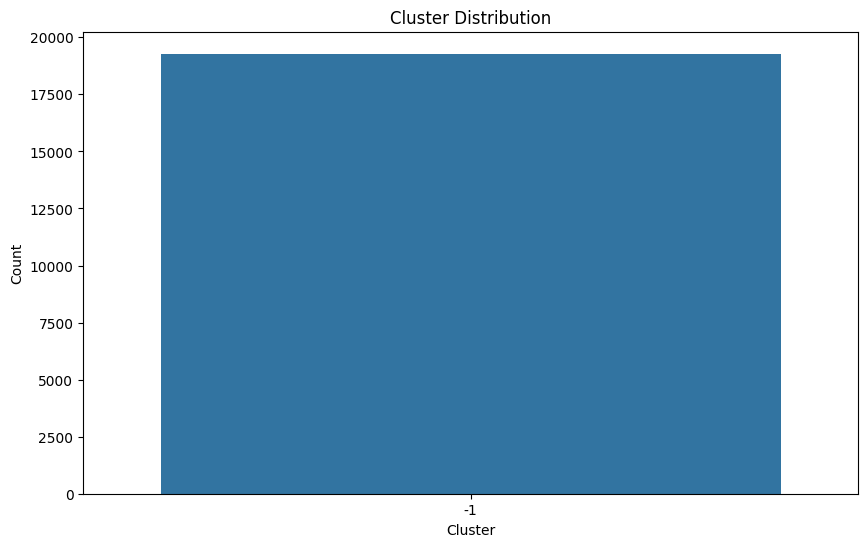

In [ ]:
# Plot train_cluster["cluster"]
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=train_cluster)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

In [ ]:
train_cluster["cluster"].value_counts()

,count
cluster,
0,19280


In [ ]:
train

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,y_nel,fold
0,0,0,0,0,0,NaN,NaN,0,0,6.0,0,0,0,0,0,6.0,0,NaN,2.0,0,6.0,2.0,0,2.0,2.0,0,0,0,0,2016,0,0,0,0,2.0,0,NaN,0,2.0,0,9.942000,2.0,0,0,0,2.0,0,0.0,90.0,0,0,0,0,8.0,0,2.0,0,10.0,0.0,42.356,-0.882797,6
1,1,1,0,1,0,2.0,8.0,1,0,6.0,1,0,0,0,1,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2008,0,1,1,1,2.0,0,72.290001,0,2.0,0,43.705002,2.0,1,0,1,2.0,1,3.0,90.0,0,1,1,0,8.0,0,2.0,1,10.0,1.0,4.672,-0.165150,5
2,2,0,0,0,0,2.0,8.0,0,0,6.0,0,0,0,0,2,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,0,0,0,2019,0,0,0,0,2.0,0,NaN,0,2.0,0,33.997002,2.0,2,0,2,2.0,0,0.0,90.0,0,1,1,0,8.0,0,2.0,0,10.0,0.0,19.793,-0.878189,3
3,3,2,0,1,0,2.0,8.0,0,0,6.0,0,0,0,0,3,6.0,0,10.0,2.0,1,6.0,2.0,0,2.0,2.0,0,1,1,0,2009,0,1,1,1,2.0,0,29.230000,0,2.0,0,43.244999,2.0,3,0,3,2.0,2,0.0,90.0,1,1,0,0,8.0,0,2.0,0,10.0,0.0,102.349,-0.885300,7
4,4,2,0,0,0,2.0,8.0,0,0,6.0,1,0,0,0,4,6.0,0,10.0,2.0,0,5.0,2.0,0,2.0,2.0,1,0,1,1,2018,0,0,0,0,2.0,0,56.810001,0,2.0,0,29.740000,2.0,4,0,0,2.0,3,1.0,90.0,0,1,1,1,8.0,0,2.0,0,10.0,0.0,16.223,-0.875422,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,7,3,4,0,2.0,8.0,0,0,6.0,1,0,0,2,3,6.0,2,10.0,2.0,1,6.0,2.0,0,2.0,2.0,1,1,1,0,2018,0,2,0,3,2.0,0,24.212000,1,2.0,0,51.136002,2.0,7,1,0,2.0,0,0.0,NaN,2,4,3,0,8.0,3,2.0,0,10.0,0.0,18.633,-0.877670,1
28796,28796,2,0,2,1,1.0,4.0,0,0,5.0,1,0,0,0,1,3.0,1,6.0,2.0,4,4.0,1.0,0,2.0,2.0,1,2,2,1,2017,0,1,1,0,1.0,0,30.770000,0,1.0,0,18.075001,2.0,8,0,0,1.0,4,3.0,90.0,0,2,1,0,6.0,1,1.0,1,8.0,1.0,4.892,-0.191762,8
28797,28797,6,3,2,3,2.0,8.0,0,2,6.0,1,0,1,2,9,6.0,1,10.0,2.0,4,6.0,2.0,1,2.0,2.0,1,3,1,0,2018,0,0,1,4,2.0,0,22.627001,0,2.0,1,51.005001,2.0,3,1,0,2.0,4,5.0,90.0,2,2,0,0,8.0,3,2.0,0,10.0,0.0,23.157,-0.879769,6
28798,28798,0,0,2,0,1.0,4.0,0,0,3.0,1,0,1,2,9,3.0,0,5.0,1.0,1,3.0,1.0,0,1.0,1.0,1,0,3,0,2018,2,0,0,0,1.0,0,58.074001,1,1.0,1,0.044000,1.0,2,0,3,1.0,5,1.0,90.0,0,1,1,1,4.0,0,1.0,0,5.0,0.0,52.351,-0.883146,9


In [ ]:
train[FEATURES].isna().sum()

,0
dri_score,0
psych_disturb,0
cyto_score,0
diabetes,0
hla_match_c_high,4620
hla_high_res_8,5829
tbi_status,0
arrhythmia,0
hla_low_res_6,3270
graft_type,0


In [ ]:
# Drop columns with na
train_fill = train.dropna()
train_fill = train_fill.drop("fold", axis=1)

In [ ]:
train_fill.reset_index(inplace=True)

In [ ]:
%%time
FOLDS = 10
def create_stratified_folds(data, target, n_splits=10):
    data['fold'] = -1
    # num_bins = int(np.floor(1 + np.log2(len(data))))  # Sturges' rule for binning
    if (target!="race_group"):
        data['bins'] = pd.qcut(data[target], q=50, duplicates='drop',labels=False)
    data["bins"]=data["race_group"]
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (_, val_idx) in enumerate(skf.split(data, data['bins'])):
        data.loc[val_idx, 'fold'] = fold

    data = data.drop(columns=['bins'])
    return data

train_fill=create_stratified_folds(train_fill,"race_group",FOLDS)

CPU times: user 16.8 ms, sys: 0 ns, total: 16.8 ms
Wall time: 19.9 ms


In [ ]:
train.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_hi

In [ ]:
# Import train_test_split, mlpregressor, cross_validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_fill[FEATURES], train_fill["y_nel"], test_size=0.2, random_state=42)

In [ ]:
# Train simple MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [ ]:
y_pred = mlp.predict(X_valid)

In [ ]:
# Check metric
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Calculate MSE
mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error:", mse)

# Calculate RMSE
rmse = root_mean_squared_error(y_valid, y_pred)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.11066318250822062
Root Mean Squared Error: 0.3326607619004992


In [ ]:
# Cross validation with fold
# Train XGBClassifier
oof_mlp2 = np.zeros(len(train_fill))
pred_mlp2 = np.zeros(len(test_fill))

for i in range(FOLDS):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    x_train = train_fill.loc[train_fill.fold!=i,FEATURES].copy()
    y_train = train_fill.loc[train_fill.fold!=i,"efs"]
    x_valid = train_fill.loc[train_fill.fold==i,FEATURES].copy()
    y_valid = train_fill.loc[train_fill.fold==i,"efs"]
    x_test = test_fill[FEATURES].copy()

    mlp.fit(x_train, y_train)

    # INFER OOF
    oof_mlp2[train_fill.index[train_fill.fold==i]] = (mlp.predict(x_valid))
    # INFER TEST
    pred_mlp2 += (mlp.predict(x_test))

#########################
### Fold 1
#########################


ValueError: Found array with 0 sample(s) (shape=(0, 57)) while a minimum of 1 is required by MLPRegressor.

In [ ]:
train_fill.isna().sum()

,0
index,0
ID,0
dri_score,0
psych_disturb,0
cyto_score,0
diabetes,0
hla_match_c_high,0
hla_high_res_8,0
tbi_status,0
arrhythmia,0


In [ ]:
test.isna().sum()

,0
ID,0
dri_score,0
psych_disturb,0
cyto_score,0
diabetes,0
hla_match_c_high,1
hla_high_res_8,1
tbi_status,0
arrhythmia,0
hla_low_res_6,0


In [ ]:
test_fill = test.dropna()